# EDA

## Data Sources
- **Shooter information**: Peterson, J., & Densley, J. (2023). The Violence Project database of mass shootings in the United States (Version 7). https://www.theviolenceproject.org
- **Mental Illness Information**: States with the highest levels of mental health illness - NiceRx. https://worldpopulationreview.com/state-rankings/mental-health-statistics-by-state
- **Arrests by State**: Federal Bureau of Investigation (2018). https://ucr.fbi.gov/crime-in-the-u.s/2018/crime-in-the-u.s.-2018/topic-pages/tables/table-69 (Data for Iowa based on 2019 figures due to lack of information in 2018)
- **Autism prevalence**: National Library of Medicine, J Autism Dev Disord. 2020 Dec; 50(12): 4258–4266. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9128411/table/T2/
- **Other census datan**: U.S. Census Bureau (2018-2021). Accessed through `census` Python module API

In [1]:
import pandas as pd
from pathlib import Path

import seaborn as sns
from matplotlib import pyplot as plt

# Ignnore warning
import warnings
warnings.simplefilter(action='ignore')

## Functions

In [2]:
def corr_heatmap(corr_matrix, title='Correlation Matrix'):
    # Display correlation matrix
    fig, ax = plt.subplots(figsize=(8,6))

    sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        ax=ax,
        cmap="Blues"
        )

    ax.set_title(title)

    plt.show()

## Import data

In [3]:
csv = Path('../Datasets/clean_data/clean_shooters_v8.csv')

In [4]:
shooters_df = pd.read_csv(csv)
shooters_df.head()

,Age,Gender,Race,Immigrant,Education,RelStatus,Employed,Work,MilService,Arrested,ParentDivorce,SES,MentalIllness,MentalIllnessHistory,Autism,HealthIssues,Classification
0,25,Male,White,No,Some college/trade school,Married,No,Unknown,Yes,Yes,No evidence,Middle class,Yes,No evidence,No evidence,Yes,1
1,18,Male,White,No,Less than high school,Single,No,Unknown,No,No,No evidence,Middle class,Yes,No evidence,No evidence,No evidence,1
2,39,Male,White,No,Some college/trade school,Married,Yes,In between,Yes,No,No evidence,Middle class,No evidence,No evidence,No evidence,No evidence,1
3,56,Male,White,No,Unknown,Single,Yes,Blue collar,No,Yes,No evidence,Unknown,No evidence,No evidence,No evidence,No evidence,1
4,31,Male,Black,No,Some college/trade school,Married,No,In between,Yes,No,Yes,Middle class,Yes,No evidence,No evidence,No evidence,1


## Feature engineering

In [5]:
shooters_feat_eng_df = shooters_df.copy().drop(columns='Classification')

### Replace the categorical features with only 2 values by binary features 

In [6]:
# Get all the features with only two unique values in a list
mask = shooters_feat_eng_df.nunique()==2
feature_with_2_values = list(shooters_feat_eng_df.nunique()[mask].index)

# Change all the 2-value features to binary columns (1 = 'Yes', 0 = 'No')
for feat in feature_with_2_values:
    shooters_feat_eng_df[feat] = [1 if c=='Yes' else 0 for c in shooters_df[feat]]

In [8]:
shooters_feat_eng_df.head()

,Age,Gender,Race,Immigrant,Education,RelStatus,Employed,Work,MilService,Arrested,ParentDivorce,SES,MentalIllness,MentalIllnessHistory,Autism,HealthIssues
0,25,Male,White,0,Some college/trade school,Married,0,Unknown,1,1,0,Middle class,1,0,0,1
1,18,Male,White,0,Less than high school,Single,0,Unknown,0,0,0,Middle class,1,0,0,0
2,39,Male,White,0,Some college/trade school,Married,1,In between,1,0,0,Middle class,0,0,0,0
3,56,Male,White,0,Unknown,Single,1,Blue collar,0,1,0,Unknown,0,0,0,0
4,31,Male,Black,0,Some college/trade school,Married,0,In between,1,0,1,Middle class,1,0,0,0


### Analyse the categorical features

In [17]:
# Get all the categorical features in a list
feature_categorical = list(shooters_feat_eng_df.dtypes[shooters_feat_eng_df.dtypes == 'object'].index)
feature_categorical

['Gender', 'Race', 'Education', 'RelStatus', 'Work', 'SES']

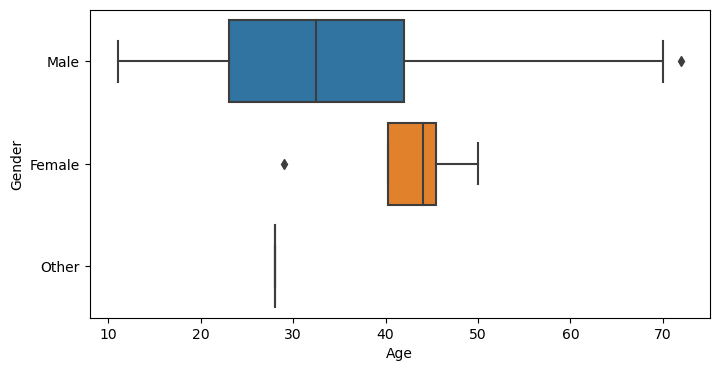

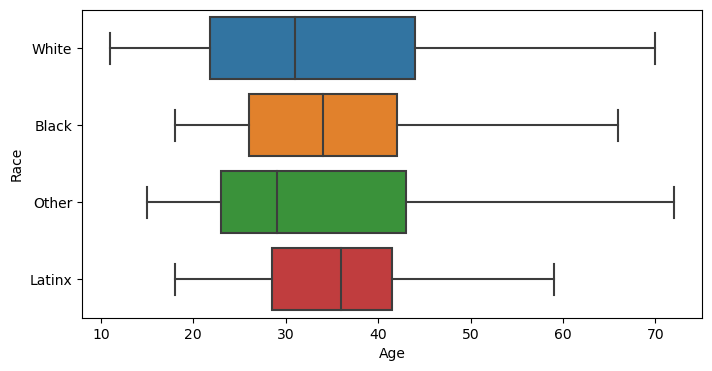

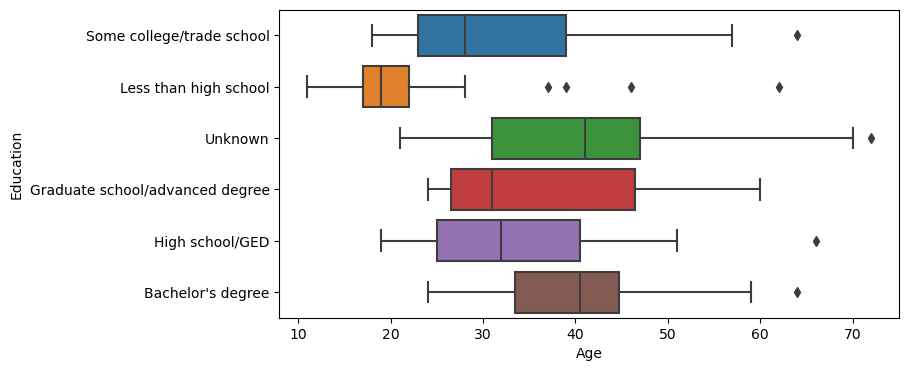

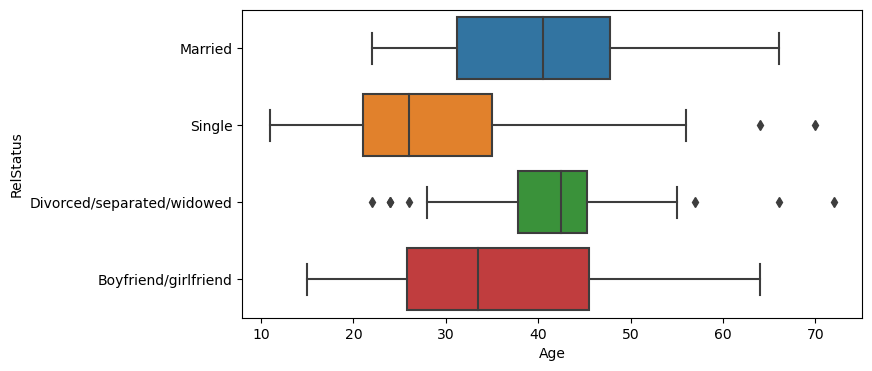

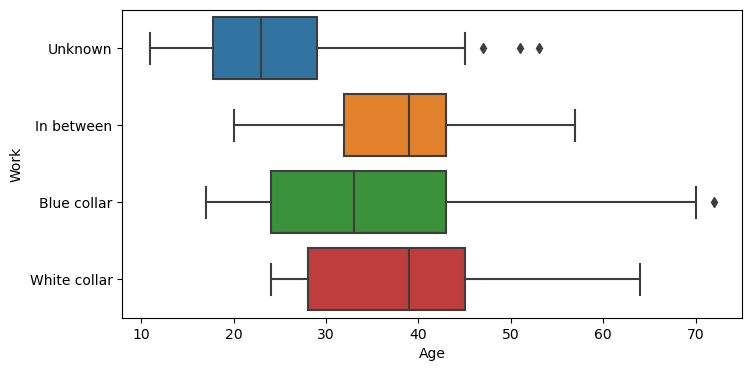

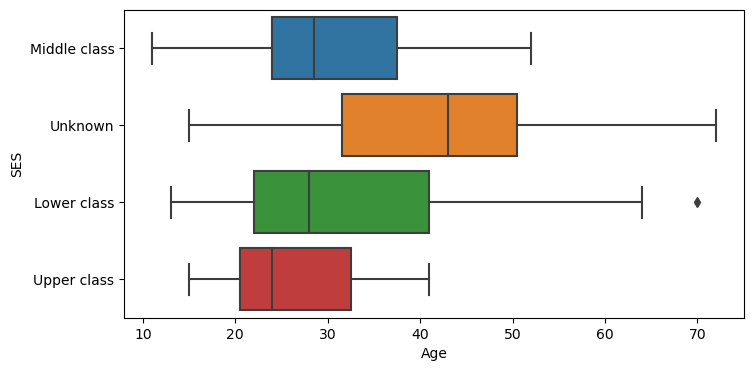

In [116]:
for feat in feature_categorical:
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.boxplot(
        shooters_feat_eng_df,
        y = feat,
        x = 'Age'
    )
    plt.show()

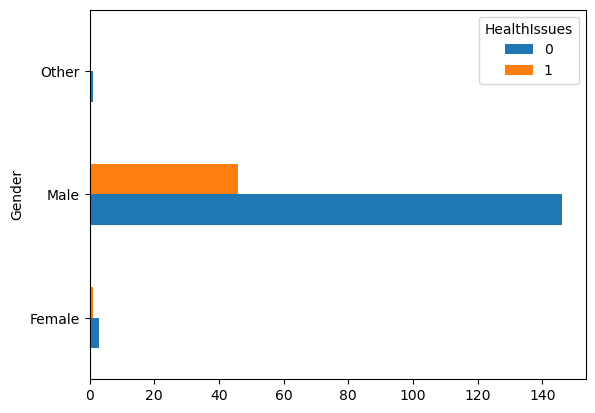

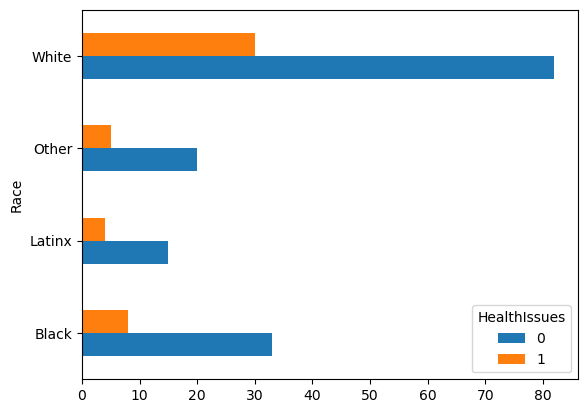

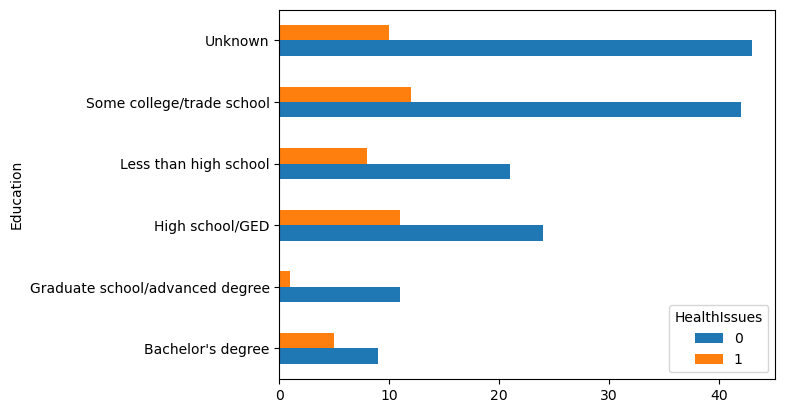

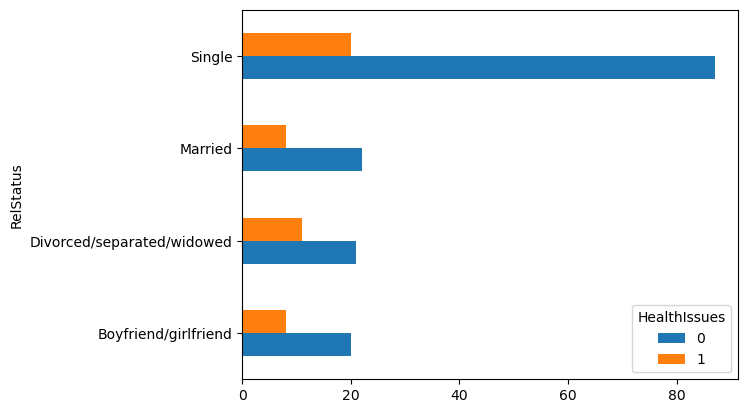

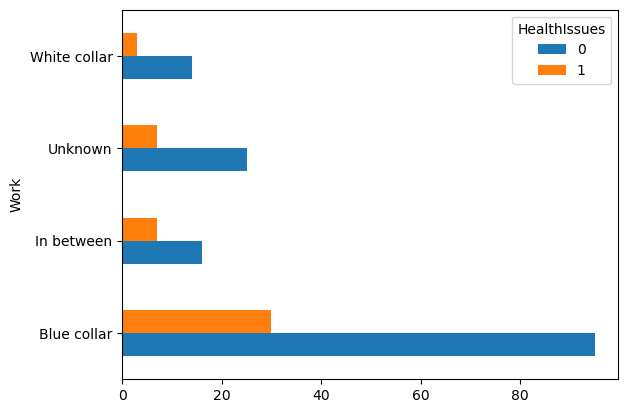

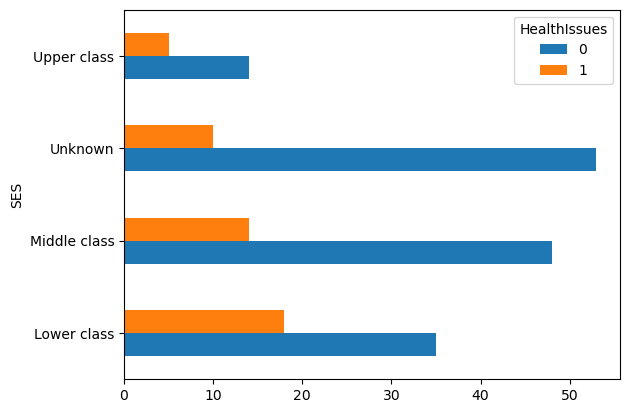

In [124]:
feat = feature_with_2_values[8]

for y in feature_categorical:

    feature_feature_df = pd.DataFrame(shooters_feat_eng_df[[feat,y]].groupby([feat,y], as_index=False).value_counts()).rename(columns={0:'Count'})

    pivot = feature_feature_df.pivot_table(
        index=y,
        columns=feat,
        values='count'
    )

    pivot.plot.barh()
    plt.show()

## Correlation Matrix (shooter data only)
The different features of the dataset are very weakly correlated, if at all.

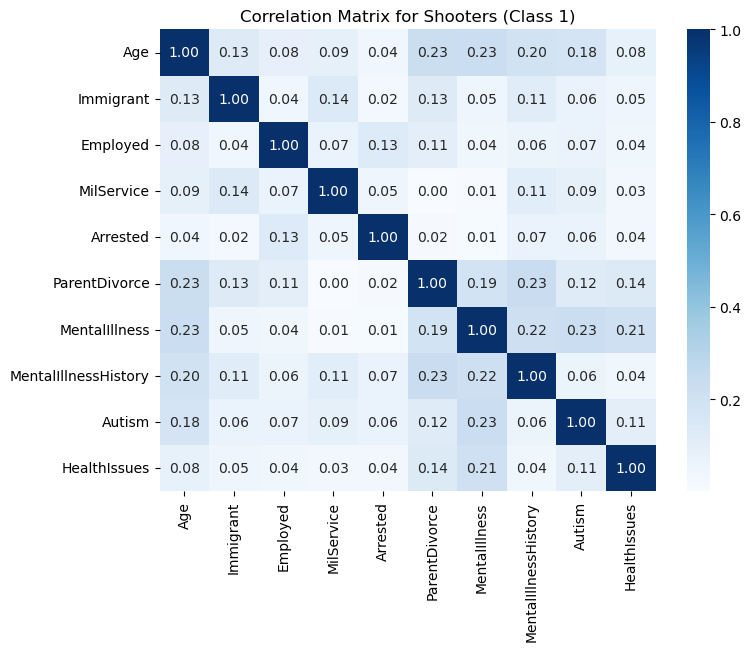

In [107]:
# Calculate correlation matrix (absolute values)
corr_matrix = shooters_feat_eng_df.corr(numeric_only=True).abs()

# Display correlation matrix as a heatmap
title = 'Correlation Matrix for Shooters (Class 1)'
corr_heatmap(corr_matrix, title)

## Comparison with general population statistics

In [125]:
# Count male shooter proportion
shooters_df['Gender'].value_counts()[0]/len(shooters_df['Gender'])

0.9746192893401016

count    50.000000
mean     21.924600
std       2.621866
min      17.490000
25%      20.512500
50%      21.500000
75%      23.580000
max      29.680000
Name: RatesOfMentalIllness, dtype: float64


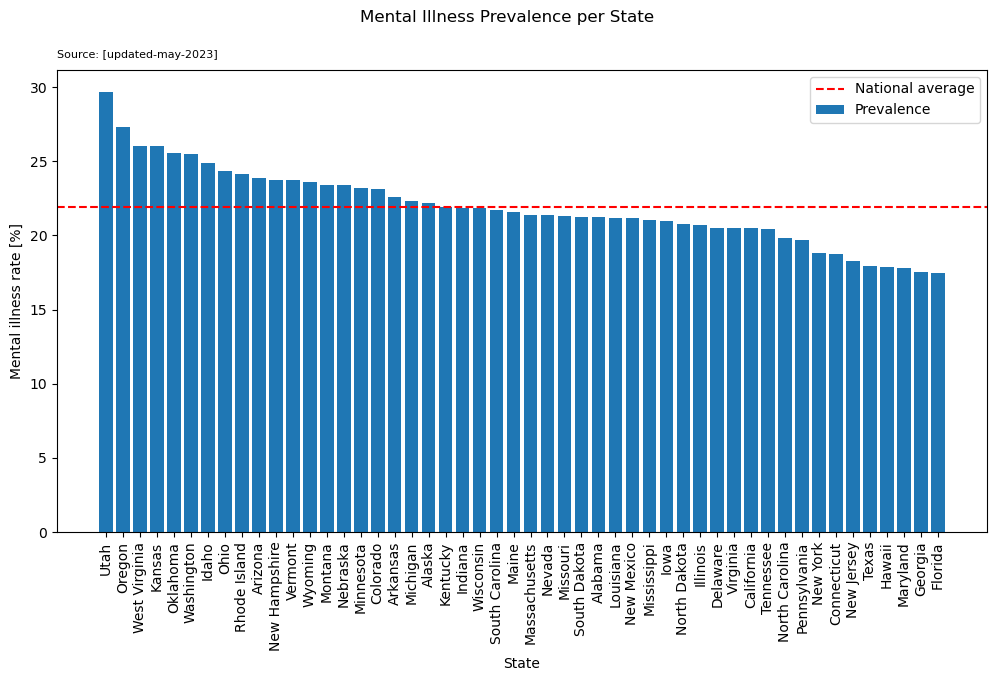

In [126]:
csv = Path('../Datasets/raw_data/mental-health-statistics-by-state-[updated-may-2023].csv')
cases_df = pd.read_csv(csv)

cases_df.describe()

cases_df['state'].nunique()

print(f"{cases_df['RatesOfMentalIllness'].describe()}")

fig, ax = plt.subplots(figsize=(12,6))

ax.bar(cases_df['state'], cases_df['RatesOfMentalIllness'], label='Prevalence')
ax.axhline(cases_df['RatesOfMentalIllness'].mean(), ls='--', c='r', label='National average')

ax.set_xticklabels(cases_df['state'], rotation=90)
ax.set_xlabel('State')

ax.set_ylabel('Mental illness rate [%]')

fig.suptitle('Mental Illness Prevalence per State')
fig.text(x=0.125, y=0.9, s='Source: [updated-may-2023]', fontsize=8)

ax.legend()

plt.show()

## Age distribution (general male population)

In [127]:
genpop_df = pd.read_csv('../Datasets/clean_data/clean_male_population_age.csv')

# Drop Puerto Rico
genpop_df = genpop_df.loc[genpop_df['state'] != 'PR',:]

# Get country-wide age distribution
age = pd.DataFrame(genpop_df.sum()).T.drop(columns=['state', 'Total Population'])

In [128]:
# Group ages in equal buckets of 10 years
decades = pd.DataFrame({
    '<10': age['Under 10 years old'],
    '10-19': age['10 to 14 years'] + age['15 to 17 years'] + age['18 and 19 years'],
    '20-29': age['20 years'] + age['21 years'] + age['22 to 24 years'] + age['25 to 29 years'],
    '30-39': age['30 to 34 years'] + age['35 to 39 years'],
    '40-49': age['40 to 44 years'] + age['45 to 49 years'],
    '50-59': age['50 to 54 years'] + age['55 to 59 years'],
    '60-69': age['60 and 61 years'] + age['62 to 64 years'] + age['65 and 66 years'] + age['67 to 69 years'],
    '>70': age['70 to 74 years'] + age['75 years and over']
}).T.reset_index()

In [129]:
shooter_age = pd.DataFrame(shooters_df['Age'])

bins = [0, 10, 20, 30, 40, 50, 60, 70, 100]
group_names = decades['index'].values

shooter_age['Bracket'] = pd.cut(shooters_df["Age"], bins, labels=group_names, include_lowest=True)
shooter_age = pd.DataFrame(shooter_age['Bracket'].value_counts())
shooter_age = shooter_age.T[decades['index'].values].T

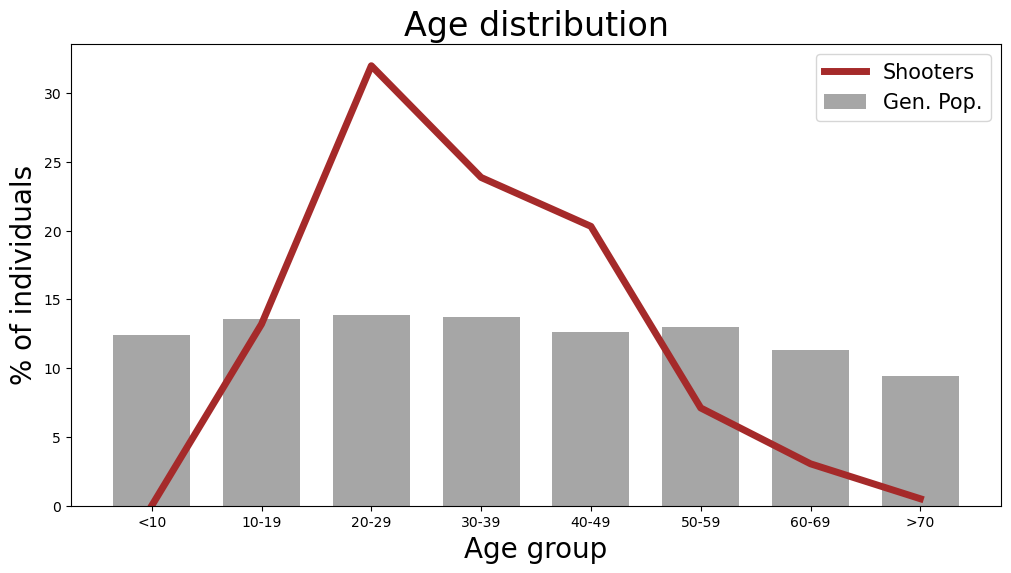

In [134]:
# Create figure
fig, ax = plt.subplots(figsize=(12,6))

# Add genpop and shooters age distribution
ax.bar(decades['index'], 100*decades[0]/decades[0].sum(), label='Gen. Pop.', width=0.7, facecolor='#A6A6A6')
ax.plot(decades['index'], 100*shooter_age['Bracket']/shooter_age['Bracket'].sum(), label='Shooters', c='#A52A2A', linewidth=5)

# Add labels and information
ax.set_title('Age distribution', fontsize=24)
ax.set_xlabel('Age group', fontsize=20)
ax.set_ylabel('% of individuals', fontsize=20)
ax.legend(fontsize=15)

# Show plot
plt.show()

## Arrest rate

In [131]:
arrests = pd.read_csv('../Datasets/raw_data/FBI_2018_crimeByStates.csv')
100*arrests['Rate'].mean()

2.8922233117647056

## Unemployment

In [132]:
unemployment = pd.read_csv('../Datasets/raw_data/unemployment-rate-by-state-[updated-august-2023].csv')
unemployment['unemploymentRateJuly2022'].mean()

3.288235294117647

## Autism

In [133]:
autism = pd.read_csv('../Datasets/clean_data/clean_autism.csv')
autism['Prevalence'].mean()

2.1876470588235293